In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set()

C:\Users\ivypa\Anaconda3\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### Random Forest

Данные в [файле](http://www.machinelearning.ru/wiki/images/3/32/Titanic.zip).

In [2]:
titanic = pd.read_csv('train.csv')
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
titanic.shape

(891, 12)

Выберем признаки для анализа:

In [4]:
feature_names = ["Sex", "Age", "SibSp", 'Pclass', 'Parch', 'Fare']

target = titanic["Survived"].copy()
data = titanic[feature_names].copy()
data["Age"].fillna(data["Age"].mean(), inplace=True)
data["Sex"] = list(map(int, data["Sex"] == 'male'))

700 первых в трейн, 191 последних в тест.

Обучим обычное дерево:

In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=15)
clf.fit(data[:700], target[:700])
np.mean(target[700:]==clf.predict(data[700:]))

0.81675392670157065

RandomForest ([Документация](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)):

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=30, 
                            oob_score=True)
rf.fit(data.iloc[:700], target.iloc[:700])
np.mean(target.iloc[700:] == rf.predict(data.iloc[700:]))

0.8534031413612565

In [7]:
rf.oob_score_

0.80571428571428572

Чем больше деревьев, тем лучше.

Всегда стоит указывать n_jobs=-1, тогда обучаться будет быстрее.

А вот глубина и количество признаков — это уже натсраиваемый параметр.

RF позволяет определять важности признаков:

<a list of 6 Text xticklabel objects>

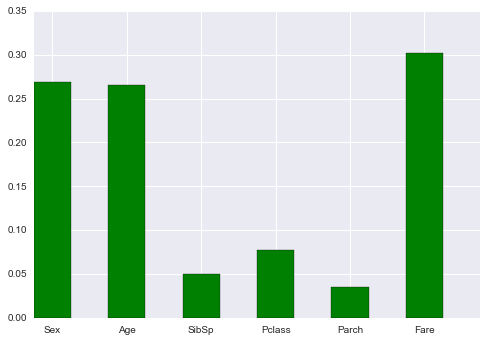

In [8]:
importance = rf.feature_importances_
idx = np.arange(importance.size)
width = 0.5
p1 = plt.bar(idx, rf.feature_importances_, width, color='g')
plt.xticks(idx+width/2, ("Sex", "Age", "SibSp", 'Pclass', 'Parch', 'Fare'))[1]

Удалим наименее важные признаки:

In [9]:
feature_names = ["Sex", "Age", 'Pclass', 'Fare']

target = titanic["Survived"].copy()
data = titanic[feature_names].copy()
data["Age"].fillna(data["Age"].mean(), inplace=True)
data["Sex"] = list(map(int, data["Sex"] == 'male'))

clf = RandomForestClassifier(1000, max_depth=10)
clf.fit(data.iloc[:700], target.iloc[:700])
np.mean(target.iloc[700:]==clf.predict(data.iloc[700:]))

0.86387434554973819

Качество улучшилось!

<a list of 4 Text xticklabel objects>

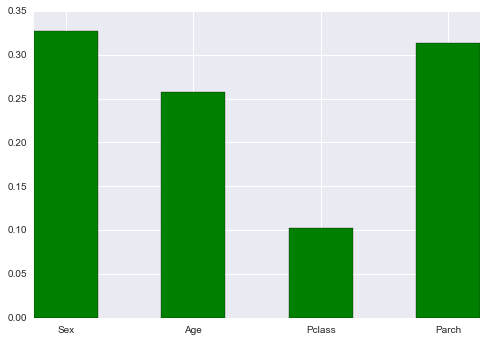

In [10]:
importance = clf.feature_importances_
idx = np.arange(importance.size)
width = 0.5
p1 = plt.bar(idx, clf.feature_importances_, width, color='g')
plt.xticks(idx+width/2, ("Sex", "Age", 'Pclass', 'Parch', 'Fare'))[1]

А что, если бы мы добавили ответ в качестве признака?

In [11]:
feature_names = ["Sex", "Age", "SibSp", 'Pclass', 'Parch', 'Fare', "Survived"]

target = titanic["Survived"].copy()
data = titanic[feature_names].copy()
data["Age"].fillna(data["Age"].mean(), inplace=True)
data["Sex"] = list(map(int, data["Sex"] == 'male'))

In [12]:
rf = RandomForestClassifier(1000, max_depth=10, oob_score=True)
rf.fit(data.iloc[:700], target.iloc[:700])
np.mean(target.iloc[700:]==rf.predict(data.iloc[700:]))

1.0

In [13]:
rf.oob_score_

1.0

<a list of 7 Text xticklabel objects>

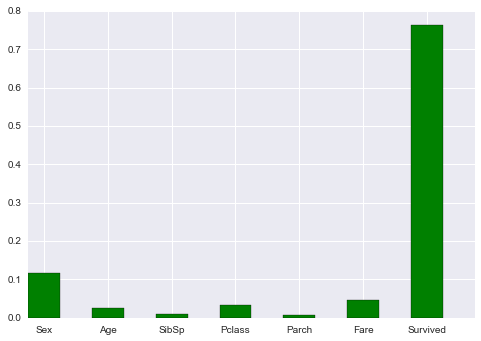

In [14]:
importance = rf.feature_importances_
idx = np.arange(importance.size)
width = 0.5
p1 = plt.bar(idx, rf.feature_importances_, width, color='g')
plt.xticks(idx+width/2, ("Sex", "Age", "SibSp", 'Pclass', 'Parch', 'Fare', 'Survived'))[1]

Отбор признаков работает! :)

### Метод главных компонент (PCA)

Сгенерируем двумерную выборку:

(-3.0, 3.0, -1.0, 1.0)

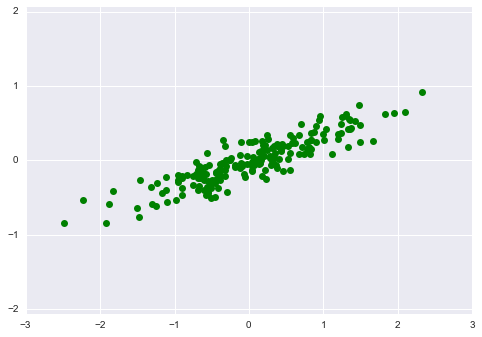

In [15]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'og')
plt.axis('equal')

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_)
print(pca.components_)

[ 0.75871884  0.01838551]
[[ 0.94446029  0.32862557]
 [ 0.32862557 -0.94446029]]


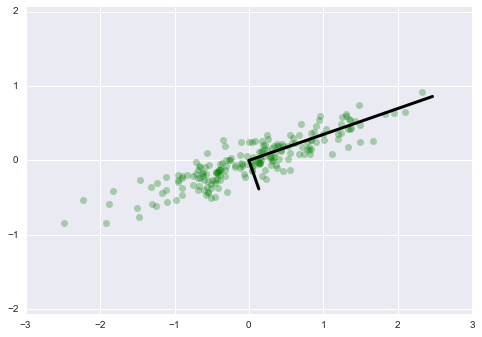

In [17]:
plt.plot(X[:, 0], X[:, 1], 'og', alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

Заметим, что одна компонента очень важна, когда вторая — не очень. Можно предположить, что вторая главная компонента может быть опущена без большой потери информации. Давайте посмотрим, что будет, если мы будем объяснять только 95% дисперсии:

In [18]:
clf = PCA(0.95)
X_trans = clf.fit_transform(X)
print(X.shape)
print(X_trans.shape)

(200, 2)
(200, 1)


Мы не объясняем всего 5% дисперсии, но сжали данные в два раза. Давайте посмотрим на то, что получилось после сжатия:

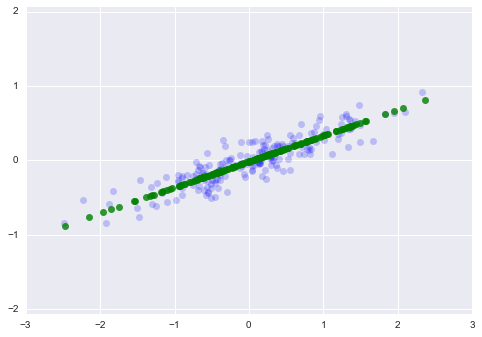

In [19]:
X_new = clf.inverse_transform(X_trans)
plt.plot(X[:, 0], X[:, 1], 'ob', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'og', alpha=0.8)
plt.axis('equal');

Синие точки — исходные данные, а зелёные — после проекции и обратного преобразования.

##### Применим PCA к цифрам

Одно из преимуществ PCA в том, что он позволяет визуализировать данные большой размерности:

In [20]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [21]:
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
print(X.shape)
print(Xproj.shape)

(1797, 64)
(1797, 2)


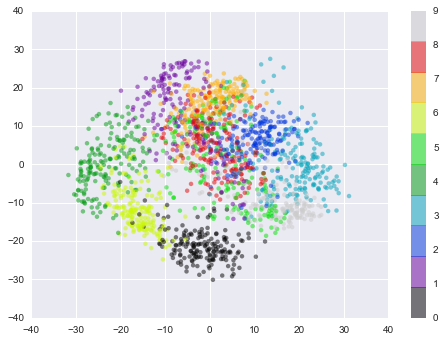

In [22]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

Давайте посмотрим, сколько информации мы теряем:

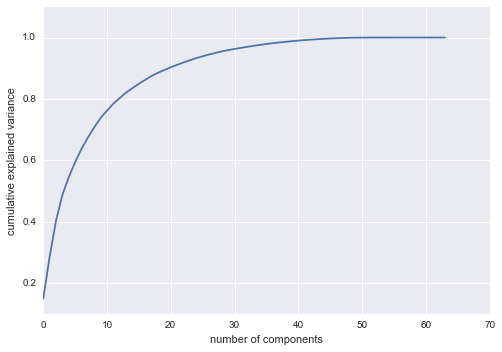

In [23]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Мы видим, что двухмерная проекция теряет слишком много информации, но вот проекция на 39-мерное пространство сохраняет почти всю информацию.

Посмотрим теперь на то, как выглядят цифры при различных $n$:

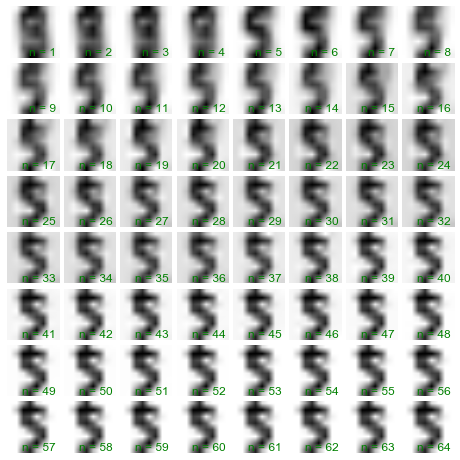

In [24]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    pca = PCA(i + 1).fit(X)
    im = pca.inverse_transform(pca.transform(X[120:121]))

    ax.imshow(im.reshape((8, 8)), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(i + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

А теперь интерактивчик:

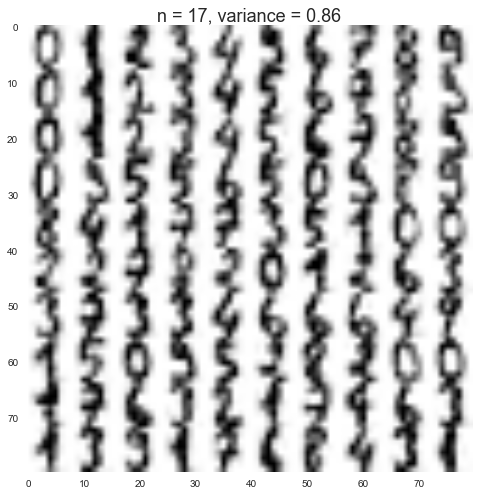

In [25]:
from IPython.html.widgets import interact

def plot_digits(n_components):
    plt.figure(figsize=(8, 8))
    nside = 10
    
    pca = PCA(n_components).fit(X)
    Xproj = pca.inverse_transform(pca.transform(X[:nside ** 2]))
    Xproj = np.reshape(Xproj, (nside, nside, 8, 8))
    total_var = pca.explained_variance_ratio_.sum()
    
    im = np.vstack([np.hstack([Xproj[i, j] for j in range(nside)])
                    for i in range(nside)])
    plt.imshow(im)
    plt.grid(False)
    plt.title("n = {0}, variance = {1:.2f}".format(n_components, total_var),
              size=18)
    plt.clim(0, 16)
    
interact(plot_digits, n_components=[1, 64], nside=[1, 8]);